Unesite velicinu za kvadratnu matricu sa kojom zelite igru: 6
Unesite broj iteracija: 4
[[0 1 0 0 1 0]
 [1 0 0 1 1 1]
 [1 1 1 1 1 0]
 [1 0 1 0 1 1]
 [0 1 1 1 0 0]
 [0 1 0 0 1 1]]
Unesite na koliko delova zelite da vam se podeli ova matrica (maksimalan broj koji mozete uneti je velicina matrice 36, tj koliko procesa ce se pokrenuti: 3


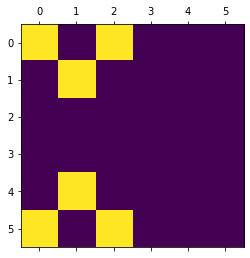

In [8]:
import numpy as np
import multiprocessing
#importi za animaciju
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import HTML

n = 0
matrix = np.array([])
deloviMatrice = 0
velMatrice = 0
brDelovaMatrice = 0
velDelaMatrice = 0
preostaliBrDelovaMatrice = 0
poslednjiDeoMatrice = 0
pomocnaLista = np.array(int)
pocetnaPozicijaZaDeo = 0
rezultat = []
listaZaSledecuIter = np.array(int)
pool = 0
nizIteracija = []
novaListaZaMatricu = list()
novaMatrica = []

def log_result(result):
    # ovo se poziva kada god procfja vraca rezultat
    # tako da se result_list menja van poola
    # pa pool moze da svoju fju izvrsava paralelno
    rezultat.append(result)

# fja koju prosledjujem procesu
# prima pocetnu poziciju koja kaze od kog polja da se kreira deo
# zatim velicinu tog dela, tj koliko se narednih polja jos uzima 
# i prosledjujem matricu, jer sam imala problem kad sam probala da menjam kao globalnu matricu
def procFja(pocetnaPoz, velicina, matrix):
    global n
    # kreiram nizove za vrednosti i koordinate polja iz prosledjenog dela 
    nizVrednosti = np.array([0 for l in range(0,velicina)])
    nizKoordinata = np.array([0 for l in range(0,velicina)])

    br = 0
    # print(nizVrednosti)

    # tren mi predstavlja na kom sam polju i iz njega deljenjem i modovanjem izvlacim vrednosti za i i j
    for tren in range(pocetnaPoz, pocetnaPoz+velicina):
        # print(f"tren je: {tren}")
        i = tren//n
        j = tren%n
        brojZivihSuseda = 0
        # prebrojavam zive susede
        for i1 in range(i-1, i+2):
            for j1 in range(j-1, j+2):
                if(i == i1 and j == j1):
                    continue
                if (matrix[i1%n][j1%n]==1):
                    brojZivihSuseda+=1
        # uzimam staru vrednost polja sa kojim trenutno radim zbog proveravanja
        staraVrednostPolja = matrix[i][j]
        # postavljam novu vrednost za polje sa kojim trenutno radim
        if(brojZivihSuseda<2):
            nizVrednosti[br] = 0
        elif(brojZivihSuseda>3):
            nizVrednosti[br] = 0
        elif(staraVrednostPolja == 1 and (brojZivihSuseda==2 or brojZivihSuseda==3)):
            nizVrednosti[br] = 1
        elif(staraVrednostPolja == 0 and brojZivihSuseda==3):
            nizVrednosti[br] = 1
        # dodajem kordinate trenutnog polja sa kojim radim u niz kordinata
        nizKoordinata[br] = tren
        br+=1
    # print(f"ovo je vrednost nizaKoordinata {nizKoordinata}")
    # print(f"ovo je vrednost nizaVrednosti {nizVrednosti}")


    # pravim tuple, tj kao parove, tako da je prva stavka u tupleu kordinata(iz koje mogu da izvucem i i j), a druga je vrednost tog polja
    # i tako imam listu parova, za ceo deo matrice i to vracam, da bih mogla u glavnom programu da konstruisem matricu sledece iteracije
    niz = list(zip(nizKoordinata,nizVrednosti))
    return niz

# n=5
# brIteracija = 10
# matrix = np.array([[0, 0, 0, 0, 0],
#                   [0, 0, 1, 0, 0],
#                   [0, 1, 1, 1, 0],
#                   [0, 0, 1, 0, 0],
#                   [0, 0, 0, 0, 0]])

n = int(input("Unesite velicinu za kvadratnu matricu sa kojom zelite igru: "))
brIteracija = int(input("Unesite broj iteracija: "))

velMatrice = n*n

# za testiranje, da ne bih svaki put unosila svoju matricu
matrix = (np.array(np.random.rand(velMatrice)).reshape(n, n) > 0.5).astype(np.int8)
print(matrix)

# print("Moguce vrednosti za polja su 0(ukoliko je celija mrtva) i 1(ukoliko je celija ziva)" )
# print(f"Unesi vrednosti polja odvojenih razmakom(space-om), potrebno je da uneseti {velMatrice} brojeva: ")
# 
# # User input of entries in a 
# # single line separated by space
# entries = list(map(int, input().split()))
#   
# # For printing the matrix
# matrix = np.array(entries).reshape(n,n)

# na koliko delova da bude odvojena matrica, tj koliko procesa je potrebno napraviti
brDelovaMatrice = int(input(f"Unesite na koliko delova zelite da vam se podeli ova matrica (maksimalan broj koji mozete uneti je velicina matrice {velMatrice}, tj koliko procesa ce se pokrenuti: "))

# ovde namestam default velDelaMatrice, ali kad mi preostane samo jedan deo za koji treba da napravim proces njemu prosledim onaj ostatak, koji je manji od velDelaMatrice
# u principu ako nije lepo deljivo zaokruzujem na veci broj, da bi poslednji proces imao manje polja koje treba da uradi
if(velMatrice%brDelovaMatrice==0):
    velDelaMatrice = (velMatrice//brDelovaMatrice)
    ostatakDelaMatrice = 0 
else:  
    velDelaMatrice = (velMatrice//brDelovaMatrice) + 1
    ostatakDelaMatrice = brDelovaMatrice * velDelaMatrice - velMatrice

# pretvorim matrix u niz, jer mi je tako bilo lakse da gledam koordinate sa kojim radim
# zato imam konvertovanje pozicije u i i j
pomocnaLista = matrix.flatten()

# na pocetku postavim da mi je preostalo da kreiram onoliko delova koliko je i zadato
# kasnije cu da smanjujem broj preostalih
# dok ne dodjem do 1, kada dodjem do 1, ukoliko mi velicina matrice nije bila lepo deljiva sa brDelovaMatrice
# taj poslednji deo ima manje celija koje treba da obradi
preostaliBrDelovaMatrice = brDelovaMatrice

# kreiram pool
pool = multiprocessing.Pool(brDelovaMatrice)

# za sve iteraciju u nizu stavim matricu koja je uneta ili setovana kao pocetna tacka
# jer cu svakako prepisivati vrednosti tih matrica
# samo mi je ovako bilo zgodnije da imam vec kreiran neki niz, pa da mu samo menjam vrednosti
# nego da svaki put appendujem novu matricu
for i in range(brIteracija):
    pom = []
    matrica = np.array([[0 for j in range(n)] for x in range(n)])
    pom.append(matrica)
    nizIteracija.append(pom)
    nizIteracija[i] = np.copy(matrix)

# print(nizIteracija)

# kreiram novu matricu sa svim setovanim 0, pa cu da je menjam na osnovu vrednosti koje mi je vratila funkcija iz poola
novaMatrica = np.array([[0 for j in range(n)] for i in range(n)])

# prolazim kroz iteracije i za svaku iteraciju kroz onoliko delova koliko je zadato
for iter in range(brIteracija):
    for k in range(brDelovaMatrice):
        # ukoliko sam na poslednjem del i vel matrice nije lepo deljiva sa brDelova matrice, onda setujem da je velicina preostali deo celija koji nije obradjen
        if(preostaliBrDelovaMatrice == 1 and velMatrice%brDelovaMatrice!=0):
            velDelaMatrice = ostatakDelaMatrice
        # prosledjujem, pocetak, velicinu i nad kojom matricom
        # vracam niz taplova(koordinata, vrednost)
        # to sve apendujem na rezultat i naknadno iteriram kroz njega
        #apply_async() nije blokirajuca metoda iz poola i onda ne znam u kom redosledu ce se zavrsiti poslovi koje im dodeljujem,
        #jer nema nikakve potrebe da se ceka da neko pre nas zavrsi, jer cilj i jeste da napravimo paralelno resenje 
        rezultat.append(pool.apply_async(procFja, args = (pocetnaPozicijaZaDeo, velDelaMatrice, matrix)))
        # resetujem promenljive koje se menjaju kako se prelazi na novi deo matrice koji se obradjuje
        preostaliBrDelovaMatrice-=1
        pocetnaPozicijaZaDeo = pocetnaPozicijaZaDeo + velDelaMatrice
    # iteriram kroz rezultate vracene za celu matricu i postavljam nove vrednosti u matricu
    for rez in rezultat:
        for x in rez.get():
            iZaMat = x[0]//n
            jZaMat = x[0]%n
            vrZaMat = x[1]
            novaMatrica[iZaMat][jZaMat] = vrZaMat
    # postavim da mi je matrix sa kojim cu na dalje da radim nova matrica
    matrix = novaMatrica
    # i dodam matricu za tu iteraciju u niz iteracija
    nizIteracija[iter] = np.copy(novaMatrica)
    # resetujem promenljive koje se menjaju prilikom prelaska na sledecu iteraciju
    preostaliBrDelovaMatrice = brDelovaMatrice
    pocetnaPozicijaZaDeo = 0
    velDelaMatrice = velMatrice//brDelovaMatrice

#zatvorim pool 
pool.close()

# animacija za iscrtavanje, samo u animate prosledjujem niz iteracija

def animate(steps):
  ''' Prima niz matrica (svaka matrica je stanje u jednom koraku simulacije) 
  prikazuje razvoj sistema'''
  
  def init():
    im.set_data(steps[0])
    return [im]
  
  
  def animate(i):
    im.set_data(steps[i])
    return [im]

  im = plt.matshow(steps[0], interpolation='None', animated=True);
  
  anim = FuncAnimation(im.get_figure(), animate, init_func=init,
                  frames=len(steps), interval=500, blit=True, repeat=False);
  return anim


anim = animate(np.array(nizIteracija));
HTML(anim.to_html5_video())
